<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [25]:
import pandas as pd
import nltk
import spacy
import numpy as np
import os

#nltk.download('punkt')
#nltk.download('stopwords')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

In [26]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
else:
    BASE_URL = "../data/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [27]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [28]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [29]:
#!python -m spacy download en_core_web_sm

In [30]:
len(df)

159571

In [33]:
df_text = np.array(df['comment_text'])
type(df_text)

nlp = spacy.load('en_core_web_sm')
eng_stopwords = nltk.corpus.stopwords.words('english')


def preprocess_text_and_store(text, doc_store=None, store=False):
    preprocessed_text = np.empty(len(text), dtype=object)
    if doc_store is None or doc_store not in os.listdir('../data/'):
        counter = 0
        for i in range(len(text)):
            process_words = []

            for word in nltk.word_tokenize(nlp(text[i].lower()).text):
                if word.isalpha() and word not in eng_stopwords:
                    process_words.append(word)
            preprocessed_text[counter] = ' '.join(process_words)
            counter += 1
    else:
        preprocessed_text = np.array(pd.read_csv('../data/'+doc_store)['comment_text'])
    if store:
        pd.DataFrame(data = {"comment_text":preprocessed_text}).to_csv(BASE_URL+doc_store)

    return preprocessed_text

preprocessed_text= preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", store=False)


numpy.ndarray

In [34]:
df_text[0]
preprocessed_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [ ]:
df = df.drop(columns=['comment_text'])

In [ ]:
df.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [ ]:
df['sum_injurious'].unique()

array([0, 4, 1, 3, 2, 5, 6])

In [ ]:
import matplotlib.pyplot as plt

def show_number(plot, hist, bin_centers):
    for i in range(len(hist)):
        plot.text(bin_centers[i], hist[i], int(hist[i]), ha='center', va='bottom', fontsize=8, fontweight='bold')

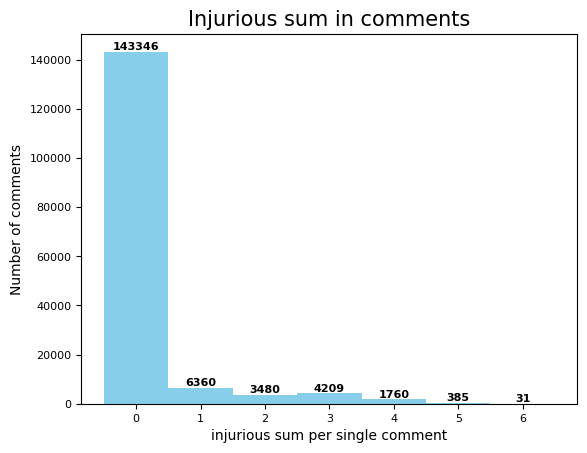

In [ ]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

hist, bins, _ = plt.hist(df['sum_injurious'], bins=len(col_names), color='skyblue')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.yticks(fontsize=8)
plt.xticks(bin_centers, col_names, fontsize=8)
plt.title('Injurious sum in comments', fontsize=15)
plt.xlabel('injurious sum per single comment', fontsize=10)
plt.ylabel('Number of comments', fontsize=10)
show_number(plt, hist, bin_centers)
plt.show();

In [ ]:
#Aggiungo barplot per vedere quali sono le classi più presenti